## CareerCon 2019 - Help Navigate Robots
Name-Aishwarya Kore
Net Id-adk497

#### The data has to be loaded in dataframes and filtered out to eliminate null and infinite values.

In [4]:
# importing necessary libraries 
import csv
import numpy as np
import pandas as pd
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
  
# loading the dataset 
#please enter the correct loaction and file name of the input dataset
df=pd.read_csv("C:/Users/admin/Desktop/aishu/study/sem2/ai/project1/data/X_train.csv")
#please enter the correct loaction and file name of the output dataset
df2=pd.read_csv("C:/Users/admin/Desktop/aishu/study/sem2/ai/project1/data/y_train.csv")
print("Raw data dimensions:",df.shape,df2.shape)

#replace poditive and negative infinite values with nan and then drop all nan values present in the data
df = df.replace([np.inf, -np.inf], np.nan)
df2=df2.replace([np.inf, -np.inf], np.nan)
df=df.dropna(how='any',axis=0)
df2=df2.dropna(how='any',axis=0)

print("Data after filtering:",df.shape,df2.shape)

Raw data dimensions: (487680, 13) (3810, 3)
Data after filtering: (487680, 13) (3810, 3)


## FEATURE CORRELATION VISUALISATION

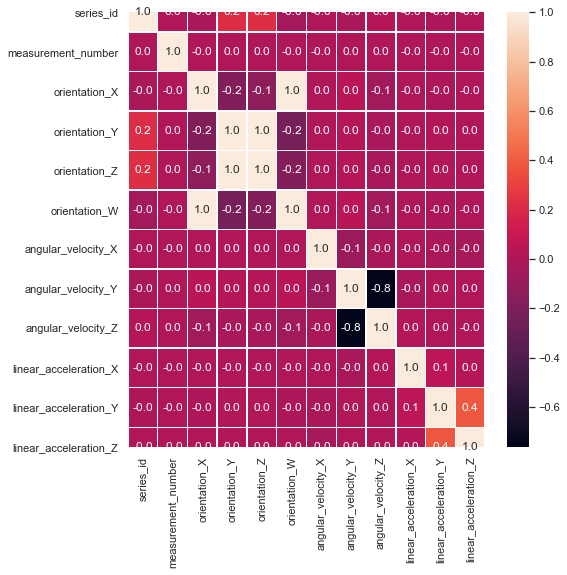

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(df.iloc[:,:].corr(), annot=True, linewidths=.5, fmt= '.1f')

### **Note that the orientation X,Y,Z,W are highly correlated with each other and affect the predictions the most

## Feature Engineering

##### Group all the entries with same series id as we have one output class per series id
##### Use various aggregate function for generating new features

In [8]:
def modify(df):
    dfnew=df[["series_id","measurement_number","orientation_X","orientation_Y","orientation_Z","orientation_W","angular_velocity_X","angular_velocity_Y","angular_velocity_Z","linear_acceleration_X","linear_acceleration_Y","linear_acceleration_Z"]]
    temp1= dfnew.groupby("series_id").mean()
    temp2= dfnew.groupby("series_id").median()
    temp3= dfnew.groupby("series_id").quantile()
    temp4=dfnew.groupby("series_id").std()
    
    df_train_mean=temp1[["orientation_X","orientation_Y","orientation_Z","orientation_W","angular_velocity_X","angular_velocity_Y","angular_velocity_Z","linear_acceleration_X","linear_acceleration_Y","linear_acceleration_Z"]]
    df_train_median=temp2[["orientation_X","orientation_Y","orientation_Z","orientation_W","angular_velocity_X","angular_velocity_Y","angular_velocity_Z","linear_acceleration_X","linear_acceleration_Y","linear_acceleration_Z"]]
    df_train_quantile=temp3[["orientation_X","orientation_Y","orientation_Z","orientation_W","angular_velocity_X","angular_velocity_Y","angular_velocity_Z","linear_acceleration_X","linear_acceleration_Y","linear_acceleration_Z"]]
    df_train_std=temp4[["orientation_X","orientation_Y","orientation_Z","orientation_W","angular_velocity_X","angular_velocity_Y","angular_velocity_Z","linear_acceleration_X","linear_acceleration_Y","linear_acceleration_Z"]]
    
    df_train_mean.rename(columns={"orientation_X":"orientation_X_mean","orientation_Y":"orientation_Y_mean","orientation_Z":"orientation_Z_mean","orientation_W":"orientation_W_mean","angular_velocity_X":"angular_velocity_X_mean","angular_velocity_Y":"angular_velocity_Y_mean","angular_velocity_Z":"angular_velocity_Z_mean","linear_acceleration_X":"linear_acceleration_X_mean","linear_acceleration_Y":"linear_acceleration_Y_mean","linear_acceleration_Z":"linear_acceleration_Z_mean"})
    df_train_median.rename(columns={"orientation_X":"orientation_X_median","orientation_Y":"orientation_Y_median","orientation_Z":"orientation_Z_median","orientation_W":"orientation_W_median","angular_velocity_X":"angular_velocity_X_median","angular_velocity_Y":"angular_velocity_Y_median","angular_velocity_Z":"angular_velocity_Z_median","linear_acceleration_X":"linear_acceleration_X_median","linear_acceleration_Y":"linear_acceleration_Y_median","linear_acceleration_Z":"linear_acceleration_Z_median"})
    df_train_quantile.rename(columns={"orientation_X":"orientation_X_q","orientation_Y":"orientation_Y_q","orientation_Z":"orientation_Z_q","orientation_W":"orientation_W_q","angular_velocity_X":"angular_velocity_X_q","angular_velocity_Y":"angular_velocity_Y_q","angular_velocity_Z":"angular_velocity_Z_q","linear_acceleration_X":"linear_acceleration_X_q","linear_acceleration_Y":"linear_acceleration_Y_q","linear_acceleration_Z":"linear_acceleration_Z_q"})
    df_train_std.rename(columns={"orientation_X":"orientation_X_std","orientation_Y":"orientation_Y_std","orientation_Z":"orientation_Z_std","orientation_W":"orientation_W_std","angular_velocity_X":"angular_velocity_X_std","angular_velocity_Y":"angular_velocity_Y_std","angular_velocity_Z":"angular_velocity_Z_std","linear_acceleration_X":"linear_acceleration_X_std","linear_acceleration_Y":"linear_acceleration_Y_std","linear_acceleration_Z":"linear_acceleration_Z_std"})
    
    X=pd.concat([df_train_mean,df_train_median,df_train_quantile,df_train_std], axis=1)
    
    return X

X=modify(df)

print("Shape of data X with new features:",X.shape)

Shape of data X with new features: (3810, 40)


### **Here I noticed that adding standard deviation as a feature made a huge change in the accuracy from 60% to 90% that is because the s.d measurement represents each of 128 data rows most accurately as a group rather that calculating mean or median because we are considering the difference with each of these 128 values.

##### Now we eliminiate the columns from the data that we do not need. Also the output values are in string we convert it to interger using a list of all the classes for better calculation putpose

In [9]:
#eliminate group_id and series_id colunms
y_train=df2[["surface"]].to_numpy()
#convert string vals in surface to interger index using this list of all classes
labels=['carpet','concrete','fine_concrete','hard_tiles','hard_tiles_large_space','soft_pvc','soft_tiles','tiled','wood']
Y= np.zeros(len(y_train))
for i in range(0,len(y_train)):
    Y[i]=labels.index(y_train[i])
Ydf=pd.DataFrame(Y)
print("New shape of Y:",Ydf.shape)

New shape of Y: (3810, 1)


## Split data into training and testing

In [11]:
import pandas as pd
# split X_train
samples = 20
start_x = X.shape[0] - samples
X_train, X_test = X.iloc[:start_x], X.iloc[start_x:]

# split y_train
start_y = Ydf.shape[0] - samples
y_train, y_test = Ydf.iloc[:start_y], Ydf.iloc[start_y:]

print("Dimensions of the training and testing data:",X_train.shape,X_test.shape,y_train.shape,y_test.shape)


Dimensions of the training and testing data: (3790, 40) (20, 40) (3790, 1) (20, 1)


## Training different models

## 1.Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
import numpy as np
from sklearn import metrics

lin_regression = LogisticRegression()
lin_regression.fit(X_train,y_train)

train_pred_lr = lin_regression.predict(X_train)

print("Logistic Regression training accuracy=",metrics.accuracy_score(y_train,train_pred_lr)) 

c:\users\admin\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Logistic Regression training accuracy= 0.4493403693931398


c:\users\admin\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [28]:
test_pred_lr=lin_regression.predict(X_test)
print("Logistic Regression tesing accuracy=",metrics.accuracy_score(y_test,test_pred_lr))

Logistic Regression tesing accuracy= 0.55


## 2.Decision Tree Classifier

In [29]:
from sklearn.tree import DecisionTreeClassifier

dmodel=DecisionTreeClassifier(splitter="random",max_depth=15).fit(X_train,y_train)
train_pred=dmodel.predict(X_train)
print("Decision tree training accuracy=",metrics.accuracy_score(y_train,train_pred)) 

Decision tree training accuracy= 0.9939313984168865


In [30]:
ypred=dmodel.predict(X_test)
print("Decision tree testing accuracy=",metrics.accuracy_score(ypred,y_test))

Decision tree testing accuracy= 0.7


## 3.Random Forest Classifier

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=16)
rf.fit(X_train,y_train);
rf_pred=rf.predict(X_train)
print("Random forest training accuracy=",metrics.accuracy_score(rf_pred,y_train))

c:\users\admin\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Random forest training accuracy= 1.0


In [45]:
rf_pred2=rf.predict(X_test)
print("Random forest testing accuracy=",metrics.accuracy_score(rf_pred2,y_test))

Random forest testing accuracy= 0.9


## 4.Multi Layer Perceptron Classifier

In [46]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(max_iter=1000)
clf.fit(X_train, y_train)
mlpy_pred=clf.predict(X_train)
print("MLP training accuracy=",metrics.accuracy_score(mlpy_pred,y_train))


c:\users\admin\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP training accuracy= 0.8100263852242744


In [47]:
mlpy_pred2=clf.predict(X_test)
print(mlpy_pred2.shape)
print("MLP testing accuracy=",metrics.accuracy_score(mlpy_pred2,y_test))

(20,)
MLP testing accuracy= 0.85


#### **From all the above models we get different accuracies so we choose the one with highest accuracy to predict the surface the robot is on and that would be the random forest classifier with an accuracy of 0.9 on testing data. 
#### **MLP also gives quite good accuracy on the data when its parameters are set right but it takes a lot of time to compute the predictions with that high value of parameters.
#### **Also our final output should be converted to strings again.

In [118]:
Y = pd.DataFrame(columns=['series_id','surface'])
k=start_y
for i in range(0,rf_pred2.shape[0]):
    j=int(rf_pred2[i])
    Y.loc[i] = k,labels[j]
    k=k+1
print("Final predicted values of surfaces for test data:")
print (Y.to_string(index=False))

Final predicted values of surfaces for test data:
series_id                 surface
     3790  hard_tiles_large_space
     3791                concrete
     3792                soft_pvc
     3793                   tiled
     3794  hard_tiles_large_space
     3795                concrete
     3796                    wood
     3797           fine_concrete
     3798                concrete
     3799                   tiled
     3800           fine_concrete
     3801  hard_tiles_large_space
     3802                   tiled
     3803                    wood
     3804                   tiled
     3805                   tiled
     3806                    wood
     3807                   tiled
     3808           fine_concrete
     3809                soft_pvc


In [120]:
#write down the predictions to a file
Y.to_csv(r'C:/Users/admin/Desktop/aishu/study/sem2/ai/project1/classification/output.csv',index=False)